In [1]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
import astropy
import gammapy
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs
gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    
)
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator, LightCurveEstimator, ESTIMATOR_REGISTRY
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line


CPU times: user 2.51 s, sys: 1.11 s, total: 3.62 s
Wall time: 5.97 s


In [2]:
#help(GaussianTemporalModel)
help(LightCurveTemplateTemporalModel)
help(GaussianTemporalModel)

Help on class LightCurveTemplateTemporalModel in module gammapy.modeling.models.temporal:

class LightCurveTemplateTemporalModel(TemporalModel)
 |  LightCurveTemplateTemporalModel(table, filename=None)
 |  
 |  Temporal light curve model.
 |  
 |  The lightcurve is given as a table with columns ``time`` and ``norm``.
 |  
 |  The ``norm`` is supposed to be a unit-less multiplicative factor in the model,
 |  to be multiplied with a spectral model.
 |  
 |  The model does linear interpolation for times between the given ``(time, norm)`` values.
 |  
 |  The implementation currently uses `scipy.interpolate. InterpolatedUnivariateSpline`,
 |  using degree ``k=1`` to get linear interpolation.
 |  This class also contains an ``integral`` method, making the computation of
 |  mean fluxes for a given time interval a one-liner.
 |  
 |  Parameters
 |  ----------
 |  table : `~astropy.table.Table`
 |      A table with 'TIME' vs 'NORM'
 |  
 |  Examples
 |  --------
 |  Read an example light curv

In [2]:
source = "Mrk501"
data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")
obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")
hdu_table



OBS_ID,HDU_TYPE,HDU_CLASS,FILE_NAME,HDU_NAME,FILE_DIR
int64,bytes6,bytes10,bytes54,bytes20,str35
55415,events,events,55415.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/Mrk501
55415,gti,gti,55415.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/Mrk501
55415,aeff,aeff_2d,55415.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/Mrk501
55415,edisp,edisp_2d,55415.anasum.fits,ENERGY DISPERSION,/Users/cedrickperron/GAMMAPY/Mrk501
55415,psf,psf_table,55415.anasum.fits,PSF,/Users/cedrickperron/GAMMAPY/Mrk501
55415,bkg,bkg_2d,55415.anasum.fits,BKG,/Users/cedrickperron/GAMMAPY/Mrk501
55416,events,events,55416.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/Mrk501
55416,gti,gti,55416.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/Mrk501
55416,aeff,aeff_2d,55416.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/Mrk501


In [4]:
data_store.obs_table
data_store.hdu_table = hdu_table

data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]




observations = data_store.get_observations(obs_id)



In [5]:

obs_table

OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST
,deg,deg,deg,deg,deg,s,s,,s,s,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20
55415,253.4666,39.260292,20.412645,69.58736,61.721607,1202.1299,1102.0688,0.9167636,192195520.0,192196720.0,4,"T1,T2,T3,T4"
55416,254.11789,39.7578,17.077888,72.92211,56.62116,1202.1155,1101.9844,0.91670424,192196770.0,192197970.0,4,"T1,T2,T3,T4"
55417,252.81706,39.759155,12.920157,77.07984,47.996296,1202.0923,1101.3605,0.9162029,192198020.0,192199220.0,4,"T1,T2,T3,T4"
55511,253.46837,40.260292,20.633823,69.36617,59.00132,1202.0623,1103.1582,0.91772133,192540200.0,192541390.0,4,"T1,T2,T3,T4"
55512,253.4666,39.260292,16.538336,73.46166,57.677967,1202.083,1101.9738,0.9167202,192541420.0,192542640.0,4,"T1,T2,T3,T4"
56127,252.81706,39.75916,15.437196,74.562805,53.910378,1201.7461,1105.6691,0.9200521,195040530.0,195041730.0,4,"T1,T2,T3,T4"
56128,253.46837,40.260292,12.290975,77.70902,42.413513,1502.2543,1382.9185,0.9205622,195041780.0,195043280.0,4,"T1,T2,T3,T4"
56152,253.4666,39.260292,21.1876,68.8124,62.304058,1802.687,1656.7118,0.9190236,195296860.0,195298670.0,4,"T1,T2,T3,T4"


In [6]:
target_position = SkyCoord(ra="253.468 deg",dec="39.7603 deg", frame="icrs")
# 0.089
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)


In [7]:
energy_axis = MapAxis.from_energy_bounds(0.2, 15, 12, unit= "TeV", name="energy")

true_energy_axis = MapAxis.from_energy_bounds(0.2, 20, 19, unit= "TeV", name="energy_true")


geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", proj="CAR")
geom_image = geom.to_image()
# IS THERE AN EXCLUSION REGION ASIDE FROM THE CENTER???
center_region = CircleSkyRegion(center=target_position, radius=0.35* u.deg)
exclusion_mask=Map.from_geom(geom_image)
exclusion_mask.data=geom_image.region_mask([center_region], inside=False)
#exclusion_mask.sum_over_axes().plot(add_cbar=True)




In [8]:
%time
e_reco = energy_axis
e_true = true_energy_axis
dataset_empty = SpectrumDataset.create(e_reco=e_reco, e_true=e_true, region=on_region)
# Create the DatasetMaker
global dataset_maker
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "psf", "edisp"])

# Create the Background Maker
#help(ReflectedRegionsBackgroundMaker)
global bkg_maker
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask, min_distance_input="0.0 deg", max_region_number=6)
#bkg_maker_for_5 = ReflectedRegionsBackgroundMaker(exclusion_mask=None, min_distance_input="0.0 deg", max_region_number=1)
#Create a Safe_mask_maker
global safe_mask_maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=1.75*u.deg, aeff_percent=10)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


In [9]:
%time
finder_list = []

for obs in observations:
    center = obs.pointing_radec
    # Here in you can add the exclusion_mask = exclusion_mask if you want
    finder = ReflectedRegionsFinder(region=on_region,center=center, exclusion_mask=None, min_distance_input="0.0 rad")
    finder.run()
    finder_list.append(finder)

    



CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 18.8 µs


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7f9d5dd8efd0>)

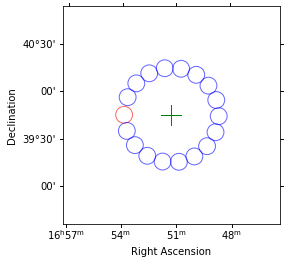

In [10]:
#5, 25, 27, 31, 38
finder_list[25].plot()

In [13]:
%%time

# Create a stacked dataset
stacked = SpectrumDatasetOnOff.create(e_reco=e_reco,  e_true=e_true, region=on_region, name="Mrk501")
exception_index_list= [5, 7, 27, 25, 26, 31, 38]
list_of_dataset = Datasets()
count = 0
for obs in observations:
    if count in exception_index_list:
        continue
    else:
        dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)
        dataset = bkg_maker.run(dataset, obs)
        dataset = safe_mask_maker.run(dataset, obs)
        list_of_dataset.append(dataset)
        print(count)
        print(dataset)
    if count == 6:
        print(bkg_maker.max_region_number)
    stacked.stack(dataset)
    count+=1

# Making sure all the datasets are in the list



0
SpectrumDatasetOnOff
--------------------

  Name                            : 55415 

  Total counts                    : 52 
  Total off counts                : 37.00
  Total background counts         : 6.17
  Total excess counts             : 45.83

  Predicted counts                : 12.71
  Predicted background counts     : 12.71
  Predicted excess counts         : nan

  Exposure min                    : 2.07e+07 m2 s
  Exposure max                    : 1.15e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 72.000

  Number of total bins            : 12 
  Number of fit bins              : 12 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 112.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


1
SpectrumDatasetOnOff
--------------------

  Name                            : 55416 

  Total counts                    : 23 
  Total off counts  

In [14]:
list_of_dataset.info_table(cumulative=True)

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
55415,52.0,6.166666666666666,45.833333333333336,9.640632980504439,12.714285714285712,12.714285714285712,nan,20700249.914744627,115179514.31629187,1102.0689186587463,1202.1298775672913,0.047183981981168376,0.005595536324689839,0.04158844565647854,12,12,wstat,112.34704241461367,37.0,12.0,72.0,0.16666666666666666
55415,75.0,9.500000953674316,65.5,11.354780511920454,18.857143962869824,18.857143962869824,nan,51291183.9694197,249886046.8499982,2204.0532757749334,2404.24536049366,0.03402821557189011,0.004310241071797217,0.029717974932784032,12,12,wstat,150.74915564800693,57.0,12.0,71.99999237060547,0.1666666865348816
55415,86.0,12.0,74.0,11.794145386987376,22.571429695401857,22.571429695401857,nan,91607854.41090842,415235265.00902116,3305.4137706247175,3606.3377043306828,0.026017922707372926,0.0036304078196334314,0.022387514887739494,12,12,wstat,156.66228119211192,72.0,12.0,72.0,0.1666666716337204
55415,107.0,16.000001907348633,91.0,12.853026090136506,29.000002065483372,29.000002065483372,nan,112250740.25377685,531221834.2017117,4408.571991914034,4808.400012224913,0.024270897741094772,0.0036292935528091587,0.020641604620931068,12,12,wstat,190.91076241653565,96.0,12.0,71.99999237060547,0.1666666865348816
55415,139.0,20.166667938232422,118.83332824707031,14.801286396378167,37.142859985633734,37.142859985633734,nan,144405363.9560106,670227917.7636632,5510.545728683035,6010.482962876558,0.02522436194957765,0.0036596498661217083,0.021564711391201953,12,12,wstat,253.8387690348414,121.0,12.0,71.99999237060547,0.1666666716337204


In [15]:

print(stacked)



 

SpectrumDatasetOnOff
--------------------

  Name                            : Mrk501 

  Total counts                    : 139 
  Total off counts                : 121.00
  Total background counts         : 20.17
  Total excess counts             : 118.83

  Predicted counts                : 37.14
  Predicted background counts     : 37.14
  Predicted excess counts         : nan

  Exposure min                    : 1.44e+12 cm2 s
  Exposure max                    : 6.70e+12 cm2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 72.000

  Number of total bins            : 12 
  Number of fit bins              : 12 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 253.84

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




Above, there is a 90 sigma significance in gammapy and a 103 sigma significance in ED. This is a huge discrespancy

In [45]:
count = 0
for a in [55415,55416,55417,55511,55512]:
    count = 0
    for l in obs_id:
        if a == l:
            print(count)
        count += 1

ss = [observations[0].pointing_radec, observations[1].pointing_radec, observations[2].pointing_radec, observations[3].pointing_radec,observations[4].pointing_radec]    
print(ss)
list_region = []
for s in ss:
    region_s= CircleSkyRegion(center=s,radius=Angle("0.1 deg"))
    list_region.append(region_s)

0
1
2
3
4
[<SkyCoord (ICRS): (ra, dec) in deg
    (253.46659851, 39.26029205)>, <SkyCoord (ICRS): (ra, dec) in deg
    (254.1178894, 39.75780106)>, <SkyCoord (ICRS): (ra, dec) in deg
    (252.81706238, 39.75915527)>, <SkyCoord (ICRS): (ra, dec) in deg
    (253.46836853, 40.26029205)>, <SkyCoord (ICRS): (ra, dec) in deg
    (253.46659851, 39.26029205)>]


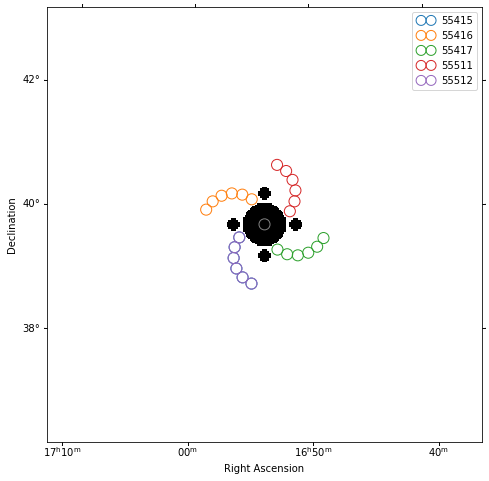

In [46]:





plt.figure(figsize=(8,8))
geom2 = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", proj="CAR")
geom2_image = geom2.to_image()
# IS THERE AN EXCLUSION REGION ASIDE FROM THE CENTER???
center2_region = CircleSkyRegion(center=target_position, radius=0.35* u.deg)
list_region.append(center2_region)
exclusion_mask2=Map.from_geom(geom2_image)
exclusion_mask2.data=geom2_image.region_mask(list_region, inside=False)
_, ax, _ = exclusion_mask2.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="grey")
plot_spectrum_datasets_off_regions(ax=ax, datasets=list_of_dataset)

In [17]:
# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = ExpCutoffPowerLawSpectralModel(amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"))


#PowerLawSpectralModel??
sky_model = SkyModel(spectral_model=spectral_model, name = "Mrk501")

joint_model = sky_model
for dataset in list_of_dataset:
    dataset.models = sky_model
    
    
# Performing a joint fit of the model:
joint_fit = Fit(list_of_dataset)
result_joint = joint_fit.run()
result_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.1594e+00,,nan,nan,False,3.250e-01
amplitude,5.3762e-12,cm-2 s-1 TeV-1,nan,nan,False,2.000e-12
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lambda_,6.0243e-02,TeV-1,nan,nan,False,2.722e-01
alpha,1.0000e+00,,nan,nan,True,0.000e+00


In [18]:
# Checking the the params of the fit to see if the fit is good. Note for the fit to be good, all plot must give a parabolic
total_stat = result_joint.total_stat

for par in list_of_dataset.models.parameters:
    if par.frozen is False:
        profile=joint_fit.stat_profile(parameter=par)
        plt.plot(profile[f"{par.name}_scan"], profile["stat_scan"]-total_stat)
        plt.xlabel(f"{par.unit}")
        plt.ylabel("Delta TS")
        plt.title(f"{par.name}: {par.value} +- {par.error}")
        plt.show()
        plt.close()

KeyboardInterrupt: 

In [ ]:
joint_model.spectral_model.covariance.plot_correlation()


In [ ]:
%%time
# Contour sigma plot. So within the circle 1sigma -> You get 
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        # alpha, beta amplitude
        for par_1, par_2 in combinations(["lambda_","index","amplitude"], r=2):
            contour = fit.minos_contour(result.parameters[par_1], result.parameters[par_2],numpoints=npoints, sigma=sigma)
            contours[f"contour_{par_1}_{par_2}"] = {par_1: contour[par_1].tolist(), par_2: contour[par_2].tolist()}
    cts_sigma.append(contours)
    
    return cts_sigma

sigma = [1]
cts_sigma = make_contours(fit=joint_fit,result=result_joint,npoints=5,sigmas=sigma)    

pars = {
    "amplitude": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "lambda_": r"$\lambda$",
    "index": r"$\gamma$",
}


panels = [
    {
        "x": "lambda_",
        "y": "amplitude",
        "cx": (lambda ct: ct["contour_lambda__amplitude"]["lambda_"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_lambda__amplitude"]["amplitude"]
        ),
    },
    {
        "x": "index",
        "y": "amplitude",
        "cx": (lambda ct: ct["contour_index_amplitude"]["index"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_index_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "lambda_",
        "y": "index",
        "cx": (lambda ct: ct["contour_lambda__index"]["lambda_"]),
        "cy": (lambda ct: ct["contour_lambda__index"]["index"]),
    },
]
fig, axes = plt.subplots(1, 2, figsize=(16,5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(ax,p["cx"](cts_sigma[ks]), p["cy"](cts_sigma[ks]),lw=2.5,color=colors[ks],label=f"{sigma[ks]}"+r"$\sigma$")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()
            

In [19]:
# STACKED DATASET:

# Defining a model to your dataset
target_position = on_region.center
#spatial_model = PointSpatialModel(lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs")

spectral_model = PowerLawSpectralModel(index=2.5, amplitude= 1.712e-11*u.Unit("1/(cm2 s TeV)"), reference = 1*u.TeV)


#PowerLawSpectralModel??
sky_model = SkyModel(spectral_model=spectral_model, name = f"{source}")

stacked_model = sky_model
stacked.models = stacked_model
  
  
# Performing a joint fit of the model:
stacked_fit = Fit(stacked)
result_stacked = stacked_fit.run()
result_stacked.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.2462e+00,,nan,nan,False,1.545e-01
amplitude,5.1244e-12,cm-2 s-1 TeV-1,nan,nan,False,6.496e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


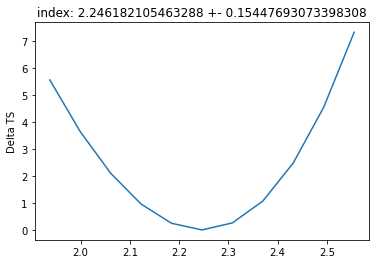

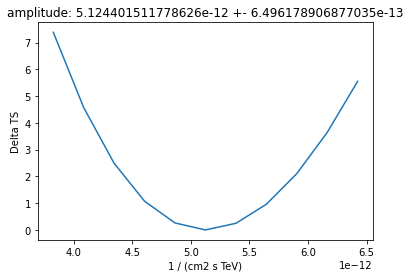

In [20]:
# Checking the the params of the fit to see if the fit is good. Note for the fit to be good, all plot must give a parabolic
total_stat = result_stacked.total_stat

for par in stacked.models.parameters:
    if par.frozen is False:
        profile=stacked_fit.stat_profile(parameter=par)
        plt.plot(profile[f"{par.name}_scan"], profile["stat_scan"]-total_stat)
        plt.xlabel(f"{par.unit}")
        plt.ylabel("Delta TS")
        plt.title(f"{par.name}: {par.value} +- {par.error}")
        plt.show()
        plt.close()

No handles with labels found to put in legend.


CPU times: user 1.07 s, sys: 45.3 ms, total: 1.12 s
Wall time: 1.23 s


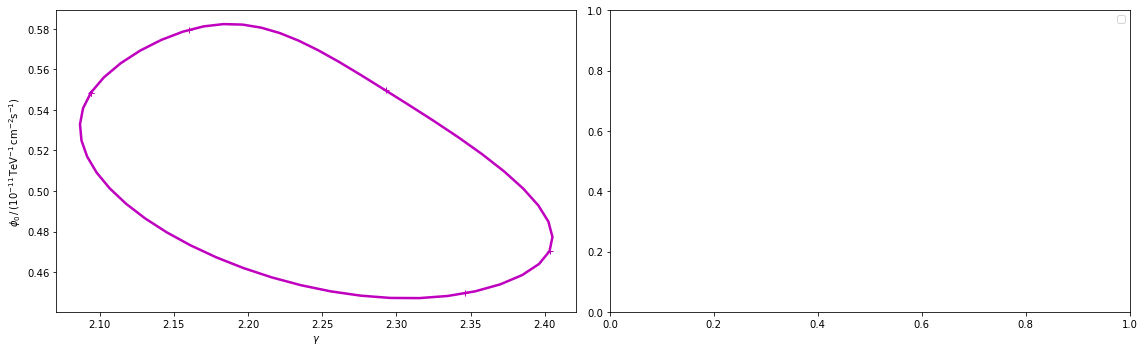

In [21]:
%%time
# Contour sigma plot. So within the circle 1sigma -> You get 
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        # alpha, beta amplitude
        for par_1, par_2 in combinations(["index","amplitude"], r=2):
            contour = fit.minos_contour(result.parameters[par_1], result.parameters[par_2],numpoints=npoints, sigma=sigma)
            contours[f"contour_{par_1}_{par_2}"] = {par_1: contour[par_1].tolist(), par_2: contour[par_2].tolist()}
    cts_sigma.append(contours)
    
    return cts_sigma

sigma = [1]
cts_sigma = make_contours(fit=stacked_fit,result=result_stacked,npoints=5,sigmas=sigma)    
pars = {    "amplitude": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "index": r"$\gamma$",    
}
panels = [
    {
        "x": "index",
        "y": "amplitude",
        "cx": (lambda ct: ct["contour_index_amplitude"]["index"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_index_amplitude"]["amplitude"]
        ),
    },
]
fig, axes = plt.subplots(1,2, figsize=(16,5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(ax,p["cx"](cts_sigma[ks]), p["cy"](cts_sigma[ks]),lw=2.5,color=colors[ks],label=f"{sigma[ks]}"+r"$\sigma$")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()
            

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9d5f879cf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d5fae4240>)

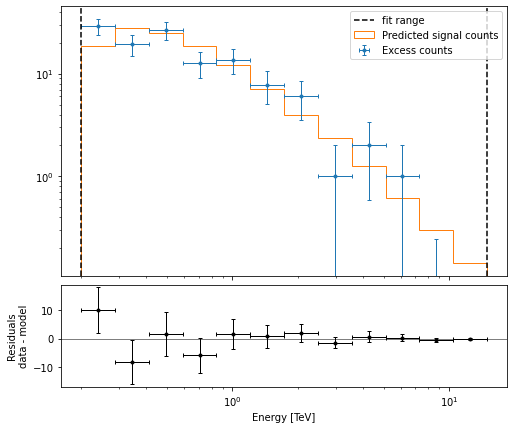

In [22]:
stacked.plot_fit()

In [23]:
# COMPARISON WITH THE JOINT-FIT
def plot_spectrum(model, result, label, color, ax=None):
    spec = model.spectral_model
    energy_range =[2, 10]*u.TeV
    spec.plot(ax=ax, energy_range=energy_range, energy_power=0, label=label, color=color)
    spec.plot_error(ax=ax, energy_range=energy_range, energy_power=0, color=color)

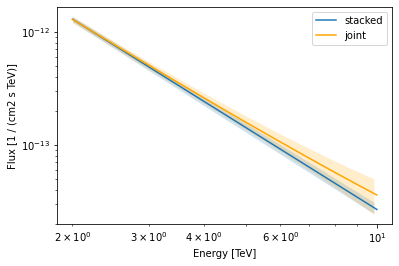

In [65]:
plot_spectrum(model=stacked_model, result=result_stacked, label="stacked", color="tab:blue")
plot_spectrum(model=joint_model, result=result_joint, label="joint", color="orange")
plt.legend()

In [66]:
%%time
# Defining the energy edges
energy_edges = np.linspace(0.3, 17, 10)*u.TeV
print(energy_edges)

# There are other parameters to FluxPointsEstimator, but I don't think that they matter a lot
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=source)

flux_points_joint = fpe.run(datasets=list_of_dataset)

[ 0.01  1.12  2.23  3.34  4.45  5.56  6.67  7.78  8.89 10.  ] TeV
CPU times: user 2min 47s, sys: 1.68 s, total: 2min 49s
Wall time: 2min 58s


In [67]:
flux_points_joint.table

counts [47],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
24 .. 82,0.376782964726437,0.15,0.94643601672029,6.758971099548923e-11,6.102455865619715e-11,1.8101105244646378e-11,9.595400526876961e-12,0.987778234120924,1100.793089556351,True,0.0294925700498097,2661.81167182016,0.0297411632056958,0.029251325870424758,1.047877154525419,0.20000000000000004 .. 5.000000000000001,2438.8256117721726 .. 7248.642120732003,51.5927482483746,6.676364537186795e-11,7.082571403314869e-11,1.9933942861808593e-12,2.0101966257426573e-12,1.977088661816887e-12
5 .. 15,1.5000000000000002,0.94643601672029,2.3773397886916703,2.5307791255220796e-12,3.7341849045394866e-12,5.278004142783332e-12,5.6942530324246815e-12,1.018178935162723,321.8696782659286,True,0.06457753830238783,556.9453291231866,0.06593441360383556,0.06327477698637948,1.1530741295565459,0.20000000000000004 .. 5.000000000000001,621.6700928233456 .. 1494.1255491906622,23.59968917429182,2.5767859951561185e-12,2.918175937261248e-12,1.6343148591328567e-13,1.6686543760212608e-13,1.6013448476919408e-13
2 .. 2,2.99289347245332,2.3773397886916703,3.7678296472643718,5.069008348973047e-13,7.09781181402358e-13,2.0946797286832947e-12,4.54051928547386e-12,1.298492760382942,107.948181474278,True,0.1924533504215707,90.88419366342394,0.2020415840287243,0.18310004449862602,1.7219605861362408,0.20000000000000004 .. 5.000000000000001,166.27158838388578 .. 257.4879433672722,9.533320180473535,6.582070643462192e-13,8.728632587727127e-13,9.755476400747774e-14,1.024150476281343e-13,9.281356542608718e-14
0 .. 0,3.8552561523198428,3.34,4.45,2.8446365264656636e-13,3.1656202230275383e-13,1.2140461069434749e-12,4.227983269285915e-12,nan,nan,False,nan,nan,nan,nan,nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan
0 .. 0,4.743416490252571,3.7678296472643718,5.97160755830246,1.784510119555707e-13,3.9568120762371504e-13,1.8528201353250476e-12,4.015147769000344e-12,1.0987777547125006,59.32951423609413,True,0.31718972226093667,16.001365789127675,0.3386415020065613,0.2887604478115109,1.8112161725460847,0.20000000000000004 .. 5.000000000000001,70.74385074275038 .. 126.34830705850516,4.0001707199977945,1.960780022427156e-13,3.2321335886114435e-13,5.660282691937056e-14,6.043091872322529e-14,5.152959412470788e-14
0 .. 0,6.089761900107425,5.5600000000000005,6.67,1.0277966542506861e-13,1.141855698448248e-13,6.940549076713681e-13,3.8116044482217545e-12,nan,nan,False,nan,nan,nan,nan,nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan
0 .. 0,7.517808504409087,5.97160755830246,9.464360167202905,6.525088316539381e-14,2.2902465934914766e-13,1.702770137982434e-12,3.687813181511319e-12,1.0300874281092547,29.662893995923305,True,0.5150434878479312,1.4716683889617101,0.565258330531932,0.7345006732368589,2.2315770481863066,0.20000000000000004 .. 5.000000000000001,30.81648643521107 .. 57.0243260070423,1.213123402198519,6.721411442169798e-14,1.4561237324577909e-13,3.3607042450662286e-14,3.688360528380465e-14,4.7926817614281376e-14
0 .. 0,8.316501668369941,7.78,8.89,5.2705201157140477e-14,5.852688468093559e-14,4.863065163958637e-13,3.645313073872696e-12,nan,nan,False,nan,nan,nan,nan,nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan


ValueError: The points in dimension 0 must be strictly ascending

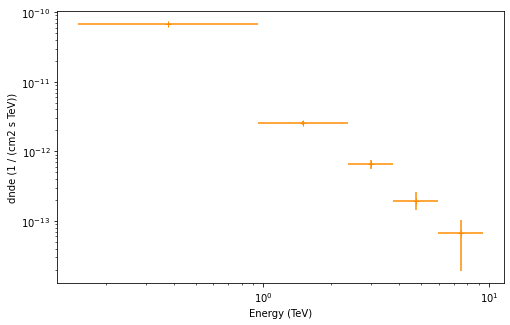

In [68]:
plt.figure(figsize=(8,5))
# To define the upper_limits and lower_limits, you do
"""

flux_points_joint["is_ul"] = flux_points_joint.table["ts"]<4 #TS threshold of 4


"""
ax = flux_points_joint.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange")
flux_points_joint.to_sed_type("dnde").plot_ts_profiles(ax=ax);

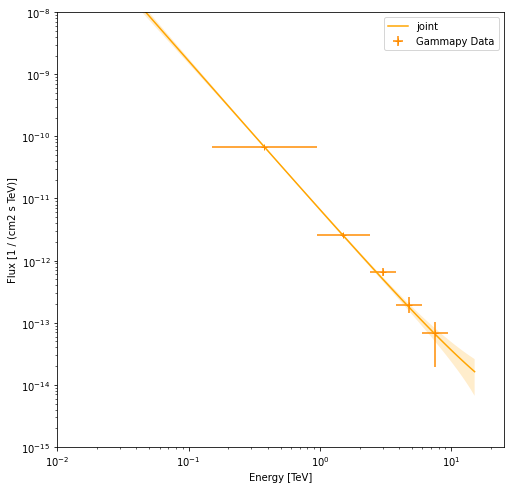

In [69]:
plt.figure(figsize=(8,8))
# Final Plot with the best-fit model, the flux points and residuals


ax_spectrum = flux_points_joint.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange", label="Gammapy Data")

"""
# Below is the same thing as above, but with the dataset, you've got a bigger range of plot. Like the residuals plot next run box
flux_points_joint_dataset= FluxPointsDataset(data=flux_points_joint,models=joint_model)
ax_spectrum = flux_points_joint_dataset.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1");
"""

# The reason we re-code this function is because we adjust the energy_range
def plot_spectrum(model, result, label, color, ax=None):
    spec = model.spectral_model
    energy_range =[0.01, 15]*u.TeV
    spec.plot(ax=ax, energy_range=energy_range, energy_power=0, label=label, color=color)
    spec.plot_error(ax=ax, energy_range=energy_range, energy_power=0, color=color)
plot_spectrum(ax=ax_spectrum,model=joint_model , result=result_joint, label="joint", color="orange")

# For the ED DATA
#ax_spectrum.errorbar(spectrum["E"], spectrum["dNdE"], yerr=spectrum["dNdE_erru"], fmt="o",label="EventDisplay")

# LIMITS OF THE GRAPH
# # DEFINIE THE AXIS BOUNDARY WITH ax (not plt)
ax_spectrum.set_xlim([0.01, 25])
ax_spectrum.set_ylim([1e-15, 1e-8])

plt.legend()

In [70]:
%%time
# REPEAT FOR STACK
# Defining the energy edges
energy_edges = np.linspace(0.01, 10, 20)*u.TeV

# There are other parameters to FluxPointsEstimator, but I don't think that they matter a lot
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=source)

flux_points_stacked = fpe.run(datasets=[stacked])

CPU times: user 4.55 s, sys: 50.8 ms, total: 4.6 s
Wall time: 4.9 s


ValueError: The points in dimension 0 must be strictly ascending

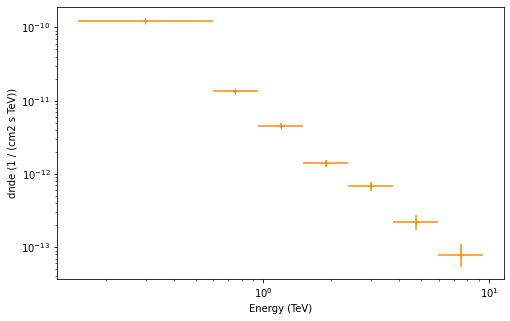

In [71]:
plt.figure(figsize=(8,5))
# To define the upper_limits and lower_limits, you do
"""

flux_points_stacked["is_ul"] = flux_points_stacked.table["ts"]<4 #TS threshold of 4


"""
ax = flux_points_stacked.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange")
flux_points_stacked.to_sed_type("dnde").plot_ts_profiles(ax=ax);

'\ndef plot_spectrum(model, result, label, color, ax=None):\n    spec = model.spectral_model\n    energy_range =[0.01, 15]*u.TeV\n    spec.plot(ax=ax, energy_range=energy_range, energy_power=0, label=label, color=color)\n    spec.plot_error(ax=ax, energy_range=energy_range, energy_power=0, color=color)\nax_spectrum = flux_points_stacked.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange", label="Stacked Data")\nplot_spectrum(ax=ax_spectrum,model=stacked_model , result=result_stacked, label="Best Fit Stacked", color="darkorange")\n'

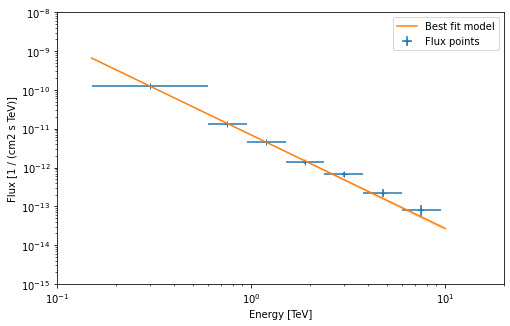

In [79]:
# PLOTTING WITH THE FLUX DATASET
plt.figure(figsize=(8,5))
flux_points_stacked_dataset= FluxPointsDataset(data=flux_points_stacked,models=stacked_model)
flux_points_stacked_dataset.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1");
plt.axis([0.10, 20, 1e-15, 1e-8])
plt.legend()



"""
def plot_spectrum(model, result, label, color, ax=None):
    spec = model.spectral_model
    energy_range =[0.01, 15]*u.TeV
    spec.plot(ax=ax, energy_range=energy_range, energy_power=0, label=label, color=color)
    spec.plot_error(ax=ax, energy_range=energy_range, energy_power=0, color=color)
ax_spectrum = flux_points_stacked.plot(energy_power=0, flux_unit="TeV-1 cm-2 s-1", color="darkorange", label="Stacked Data")
plot_spectrum(ax=ax_spectrum,model=stacked_model , result=result_stacked, label="Best Fit Stacked", color="darkorange")
"""

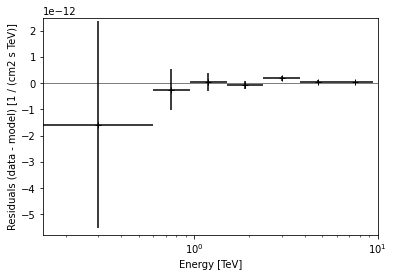

In [80]:
flux_points_stacked_dataset.plot_residuals();

EXTRACTING THE LIGHT CURVE ESTIMATOR:

In [81]:
%%time
# RUN-BY-RUN

#Step1: Create the light curve maker using the LightCurveEstimator
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], source = f"{source}", reoptimize=True)

lc_1d = lc_maker_1d.run(list_of_dataset)

CPU times: user 46.8 s, sys: 531 ms, total: 47.3 s
Wall time: 51.8 s


In [82]:
lc_1d.table

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
56046.39858751226,56046.4081107984,31.0,1.5,0.15,15.0,2.5307791255220808e-12,6.623395519287098e-11,3.0692408465130806e-11,5.6942530324246815e-12,0.706875671792659,9.363091805921357,True,0.13724242852393584,72.59268380461239,0.14561132508125685,0.1291055949257361,1.0152402303968355,0.20000000000000004 .. 5.000000000000001,35.00734383123846 .. 240.38977630488998,8.520134025038127,1.7889461945122588e-12,2.5693487824785394e-12,3.4733027324433303e-13,3.6851010195525465e-13,3.267377446261624e-13,4.681917157244555e-11,6.724337593010402e-11,9.090108861415164e-12,9.644413981006536e-12,8.551174189460155e-12
56046.40863312808,56046.42602012301,44.0,1.5,0.15,15.0,2.5307791255220808e-12,6.623395519287098e-11,3.0692408465130806e-11,5.6942530324246815e-12,0.5169629292795435,3.5395468127314773,True,0.08682504530865671,96.70568302113266,0.09118899739532528,0.08258342388837275,0.7082911083963924,0.20000000000000004 .. 5.000000000000001,25.14639266729248 .. 500.13390176911616,9.833904769781567,1.3083189900894163e-12,1.7925283519224874e-12,2.1973501223965728e-13,2.307792110853766e-13,2.090004052908353e-13,3.424049949427661e-11,4.6912921537035577e-11,5.7507661605925614e-12,6.039807967564803e-12,5.469826797496351e-12
56046.42673700024,56046.440646559844,23.0,1.5,0.15,15.0,2.5307791255220808e-12,6.623395519287098e-11,3.0692408465130806e-11,5.6942530324246815e-12,0.33782593882642686,3.8250347147957977,True,0.08325105444411514,42.29665169516475,0.08910101955886644,0.07761222785661968,0.5280592495358069,0.20000000000000004 .. 5.000000000000001,7.415503190979567 .. 426.01764394122796,6.5035876018675065,8.549628340418205e-13,1.3364013257640756e-12,2.1069003076486885e-13,2.2549500036231383e-13,1.9641940614479645e-13,2.237554809521913e-11,3.4975452672935704e-11,5.514046609810784e-12,5.901512937101081e-12,5.140564822274241e-12
56050.44149074972,56050.45540044081,38.0,1.5,0.15,15.0,2.5307791255220808e-12,6.623395519287098e-11,3.0692408465130806e-11,5.6942530324246815e-12,0.7874974697188009,10.733392804576814,True,0.14745038169627234,73.20007819111386,0.1555064615086159,0.13962655965546225,1.1150301705835535,0.20000000000000004 .. 5.000000000000001,39.64538612848986 .. 234.08241491224015,8.555704424015234,1.992982157765798e-12,2.821895080040182e-12,3.7316434804718913e-13,3.935525066698081e-13,3.533639825445074e-13,5.2159072123854326e-11,7.385285835713036e-11,9.766221974442626e-12,1.0299808003763581e-11,9.248019295954613e-12
56050.4558795943,56050.469788628485,46.0,1.5,0.15,15.0,2.5307791255220808e-12,6.623395519287098e-11,3.0692408465130806e-11,5.6942530324246815e-12,1.2244900674995733,18.895143129663417,True,0.1952243986033823,92.33420184454815,0.2048519177968822,0.18584013644692984,1.6538770583287785,0.20000000000000004 .. 5.000000000000001,72.7145262957721 .. 157.63921873598605,9.60906872930713,3.0989139022370437e-12,4.185597535398338e-12,4.94069832778042e-13,5.184349573835147e-13,4.703203380040653e-13,8.11028202648823e-11,1.0954281897586558e-10,1.2930484069651607e-11,1.3568152744532384e-11,1.230892727046298e-11
56056.41446134572,56056.42836517449,6.0,1.5,0.15,15.0,2.5307791255220808e-12,6.623395519287098e-11,3.0692408465130806

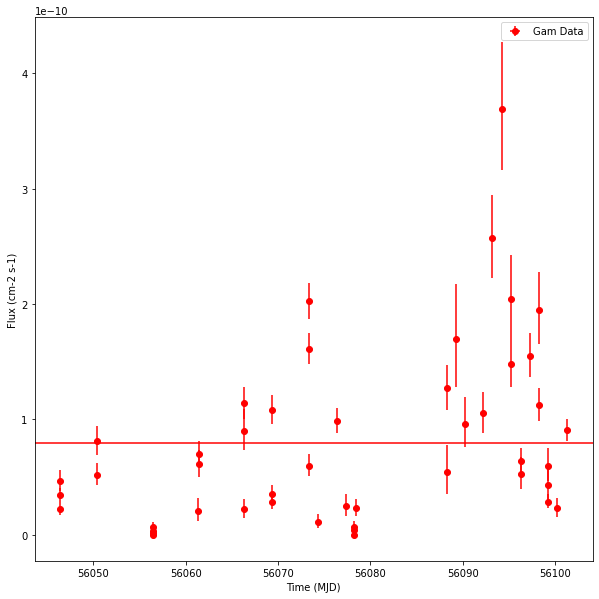

In [83]:
plt.figure(figsize=(10,10))
ax = lc_1d.plot(marker="o", color="red", label="Gam Data")
plt.axhline(y=lc_1d.table["flux"].mean(), color="red", label="Mean Flux Line Gam")

In [84]:
result_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.4078e+00,,nan,nan,False,7.013e-02
amplitude,6.3551e-12,cm-2 s-1 TeV-1,nan,nan,False,5.343e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lambda_,-3.7043e-02,TeV-1,nan,nan,False,5.373e-02
alpha,1.0000e+00,,nan,nan,True,0.000e+00


In [85]:
# NIGHT-BY-NIGHT 


# Step 1 is that we find the initial time and final time of the observations
# Step 2 is that we create the time_interval into separate night


if list_of_dataset[0].gti.time_start.value > list(lc_1d.table["time_min"])[0]:
    time_start = Time(list(lc_1d.table["time_min"])[0], format="mjd", scale="utc")
else:
    time_start = list_of_dataset[0].gti.time_start

time = time_start.value

if list_of_dataset[-1].gti.time_stop.value > list(lc_1d.table["time_max"])[-1]:
    time_end = list_of_dataset[-1].gti.time_stop
else:
    time_end = Time(list(lc_1d.table["time_max"])[-1], format="mjd", scale="utc")


time_intervals = []
count = 0
while time < (float(time_end.value)+3):
    t_plus_one = time + 1
    time_intervals.append(Time([time, t_plus_one], format="mjd", scale="utc"))
    time = t_plus_one
    for i in range(count, len(observations), 1):
        count +=1
        if float(list_of_dataset[i].gti.time_start.value) > time:
            time = int(list_of_dataset[i].gti.time_start.value)
            count = i
            break



print(time_intervals)



[<Time object: scale='utc' format='mjd' value=[[56046.39782149]
 [56047.39782149]]>, <Time object: scale='utc' format='mjd' value=[56050. 56051.]>, <Time object: scale='utc' format='mjd' value=[56056. 56057.]>, <Time object: scale='utc' format='mjd' value=[56061. 56062.]>, <Time object: scale='utc' format='mjd' value=[56066. 56067.]>, <Time object: scale='utc' format='mjd' value=[56069. 56070.]>, <Time object: scale='utc' format='mjd' value=[56073. 56074.]>, <Time object: scale='utc' format='mjd' value=[56074. 56075.]>, <Time object: scale='utc' format='mjd' value=[56076. 56077.]>, <Time object: scale='utc' format='mjd' value=[56077. 56078.]>, <Time object: scale='utc' format='mjd' value=[56078. 56079.]>, <Time object: scale='utc' format='mjd' value=[56088. 56089.]>, <Time object: scale='utc' format='mjd' value=[56089. 56090.]>, <Time object: scale='utc' format='mjd' value=[56090. 56091.]>, <Time object: scale='utc' format='mjd' value=[56092. 56093.]>, <Time object: scale='utc' format=

In [86]:
%%time
lc_maker_1d.time_intervals=time_intervals

nightwise1_lc = lc_maker_1d.run(list_of_dataset)

CPU times: user 38.5 s, sys: 348 ms, total: 38.8 s
Wall time: 38.9 s


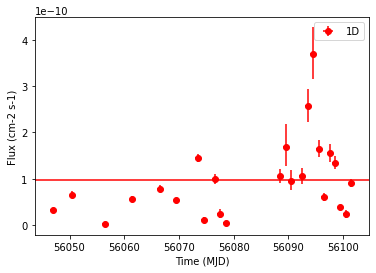

In [87]:
ax = nightwise1_lc.plot(marker="o", label="1D", color="red")
plt.axhline(y=nightwise1_lc.table["flux"].mean(), color="red")

intra-day variability of the flux

In [98]:
%%time
flux_list = list(lc_1d.table["flux"])
time_min_list = list(lc_1d.table["time_min"])
time_max_list = list(lc_1d.table["time_max"])
max_value = max(flux_list)
index = flux_list.index(max_value)
time_start = time_min_list[index]


duration = 2 * u.min
n_time_bins = 100

time_list = Time(time_start, format="mjd", scale="utc")+np.arange(n_time_bins+1)*duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(time_list[:-1], time_list[1:])]


print(time_intervals)

filt_observations = observations.select_time(time_intervals)



[<Time object: scale='utc' format='mjd' value=[56094.20364099 56094.20502988]>, <Time object: scale='utc' format='mjd' value=[56094.20502988 56094.20641877]>, <Time object: scale='utc' format='mjd' value=[56094.20641877 56094.20780766]>, <Time object: scale='utc' format='mjd' value=[56094.20780766 56094.20919655]>, <Time object: scale='utc' format='mjd' value=[56094.20919655 56094.21058544]>, <Time object: scale='utc' format='mjd' value=[56094.21058544 56094.21197433]>, <Time object: scale='utc' format='mjd' value=[56094.21197433 56094.21336322]>, <Time object: scale='utc' format='mjd' value=[56094.21336322 56094.2147521 ]>, <Time object: scale='utc' format='mjd' value=[56094.2147521  56094.21614099]>, <Time object: scale='utc' format='mjd' value=[56094.21614099 56094.21752988]>, <Time object: scale='utc' format='mjd' value=[56094.21752988 56094.21891877]>, <Time object: scale='utc' format='mjd' value=[56094.21891877 56094.22030766]>, <Time object: scale='utc' format='mjd' value=[56094

In [99]:
print(filt_observations)

Observations
Number of observations: 5
Observation

	obs id            : 63158 
 	tstart            : 56094.20
	tstop             : 56094.21
	duration          : 120.00 s
	pointing (icrs)   : 253.5 deg, 39.3 deg

	deadtime fraction : 6.8%
Observation

	obs id            : 63158 
 	tstart            : 56094.21
	tstop             : 56094.21
	duration          : 120.00 s
	pointing (icrs)   : 253.5 deg, 39.3 deg

	deadtime fraction : 6.8%
Observation

	obs id            : 63158 
 	tstart            : 56094.21
	tstop             : 56094.21
	duration          : 120.00 s
	pointing (icrs)   : 253.5 deg, 39.3 deg

	deadtime fraction : 6.8%
Observation

	obs id            : 63158 
 	tstart            : 56094.21
	tstop             : 56094.21
	duration          : 120.00 s
	pointing (icrs)   : 253.5 deg, 39.3 deg

	deadtime fraction : 6.8%
Observation

	obs id            : 63158 
 	tstart            : 56094.21
	tstop             : 56094.21
	duration          : 65.47 s
	pointing (icrs)   : 253.5 deg

In [100]:
list_dataset = Datasets()
for obs in filt_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset.models = Models(sky_model)
    list_dataset.append(dataset)
    print(dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : BasYPJYa 

  Total counts                    : 11 
  Total off counts                : 3.00
  Total background counts         : 0.50
  Total excess counts             : 10.50

  Predicted counts                : 2.78
  Predicted background counts     : 1.01
  Predicted excess counts         : 1.77

  Exposure min                    : 5.00e+02 m2 s
  Exposure max                    : 1.14e+07 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 60.000

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 23.31

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : Mrk501
    Datasets names            : None
    Spectral model type       : PowerLawSpectralM

In [ ]:
%%time
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], source = f"{source}", reoptimize=True)
lc_maker_1d.time_intervals = time_intervals
lc_day = lc_maker_1d.run(list_dataset)

In [ ]:
lc_day.table

In [ ]:
lc_day.plot(marker="o")

4 Weeks

In [94]:
%%time
# 4 weeks:
if list_of_dataset[0].gti.time_start.value > list(lc_1d.table["time_min"])[0]:
    time_start = Time(list(lc_1d.table["time_min"])[0], format="mjd", scale="utc")
else:
    time_start = list_of_dataset[0].gti.time_start

time = float(time_start.value)


if list_of_dataset[-1].gti.time_stop.value > list(lc_1d.table["time_max"])[-1]:
    time_end = list_of_dataset[-1].gti.time_stop
else:
    time_end = Time(list(lc_1d.table["time_max"])[-1], format="mjd", scale="utc")


time_intervals = []
count = 0
while time < (float(time_end.value)+3):
    t_plus_one = time + 28
    time_intervals.append(Time([time, t_plus_one], format="mjd", scale="utc"))
    time = t_plus_one
    for i in range(count, len(observations), 1):
        count +=1
        if float(list_of_dataset[i].gti.time_start.value) > time:
            time = int(list_of_dataset[i].gti.time_start.value)
            count = i
            break



print(time_intervals)



[<Time object: scale='utc' format='mjd' value=[56046.39782149 56074.39782149]>, <Time object: scale='utc' format='mjd' value=[56076. 56104.]>, <Time object: scale='utc' format='mjd' value=[56104. 56132.]>]
CPU times: user 64.8 ms, sys: 3.23 ms, total: 68 ms
Wall time: 68.1 ms


In [95]:
%%time
lc_maker_1d.time_intervals=time_intervals

four_week_lc = lc_maker_1d.run(list_of_dataset)

CPU times: user 40.4 s, sys: 522 ms, total: 40.9 s
Wall time: 47.3 s


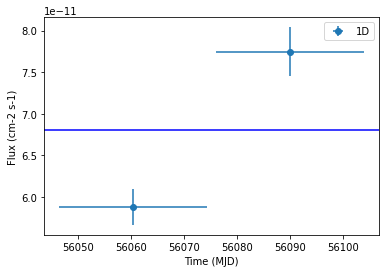

In [96]:
ax = four_week_lc.plot(marker="o", label="1D")
plt.axhline(y=four_week_lc.table["flux"].mean(), color="blue")

In [97]:
four_week_lc.table

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
56046.39858751226,56074.39858751226,933.0,1.5,0.15,15.0,2.5307791255220808e-12,6.623395519287098e-11,3.0692408465130806e-11,5.6942530324246815e-12,0.8867452085542027,865.588249864968,True,0.03231617097472705,1703.0855780283791,0.032660304719210005,0.0319744697944255,0.952746280408654,0.20000000000000004 .. 5.000000000000001,1659.3910776745945 .. 5646.558940952891,41.2684574224477,2.2441562634657e-12,2.411190398377028e-12,8.178509091964176e-14,8.265601741656699e-14,8.092032070536836e-14,5.873264241087209e-11,6.310415444676127e-11,2.140427820345229e-12,2.163221159357668e-12,2.1177955996797854e-12
56076.000766018515,56104.000766018515,957.0,1.5,0.15,15.0,2.5307791255220808e-12,6.623395519287098e-11,3.0692408465130806e-11,5.6942530324246815e-12,1.1693163837044267,738.5099382293425,True,0.044160657867682744,1643.425640488856,0.04463952958879689,0.04371247411732546,1.2595731043010212,0.20000000000000004 .. 5.000000000000001,1673.7803040159492 .. 3566.13378743889,40.53918648035325,2.959281495010131e-12,3.187701319434071e-12,1.1176087110085393e-13,1.1297278965645244e-13,1.1062661702105153e-13,7.744844896456892e-11,8.342650855241924e-11,2.9249350344958042e-12,2.9566526026152117e-12,2.895250052056467e-12
